## Imports 

In [3]:
import multiprocessing as mp

import aesara
import aesara.tensor as at
import arviz as az
import numpy as np
import numpyro
import pymc as pm
import timeit

# WFPT and LAN are two factory classes
from hssm.wfpt import WFPT
import ssms.basic_simulators

# numpyro.set_host_device_count(jax.local_device_count())

/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data 
Simulated dataset should include the following columns: 

1. response: the subject's choice on a particular trial (0=lower boundary, 1=upper boundary)
2. rt: the reaction time associated with the subject's choice

In [4]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

## Choose a log-likehood
Created a basic Wiener First Passage Time Distribution log-likehood .

In [5]:
WFPT_base = WFPT.make_ssm_distribution(
    model="base",
    list_params=["v", "a", "z", "t", "sv"],
)

## Fitting log-likelihood model into pymc model 
PyMC allows us to build WFPT mode and fit them using Markov chain Monte Carlo (MCMC) methods.

In [12]:
aesara.config.floatX = "float32"
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    sv = pm.Uniform("sv", 0.0, 1.2)

    rt = WFPT_base(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        sv=sv,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    # mp_ctx fixes parallel sampling on M1 Macs
    trace_angle_nuts = pm.sample(
        cores=1, draws=1000, tune=200, mp_ctx=mp.get_context("fork")
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Time:  42.38427416600007


## Model Evaluation 

We now want to analyze our estimated model, summary() from arviz package will print a table of summary statistics for each parameters' posterior.

In [13]:
az.summary(trace_angle_nuts)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.247,0.033,0.189,0.311,0.001,0.001,1766.0,1613.0,1.0
a,0.304,0.004,0.300,0.311,0.000,0.000,747.0,607.0,1.0
z,0.900,0.000,0.900,0.900,0.000,0.000,578.0,534.0,1.0
t,0.492,0.011,0.474,0.513,0.000,0.000,1931.0,1215.0,1.0
sv,0.659,0.001,0.658,0.660,0.000,0.000,482.0,670.0,1.0


The inference algorithm, MCMC, requires the chains of the model to have properly converged. While there is no way to guarantee convergence for a finite set of samples in MCMC, there are many heuristics that allow you identify problems of convergence. One main analysis to look at is the trace, the autocorrelation, and the marginal posterior. You can plot these using the plot_posteriors() function. For the sake of brevity we only plot three here. In practice, however, you will always want to examine all of them.

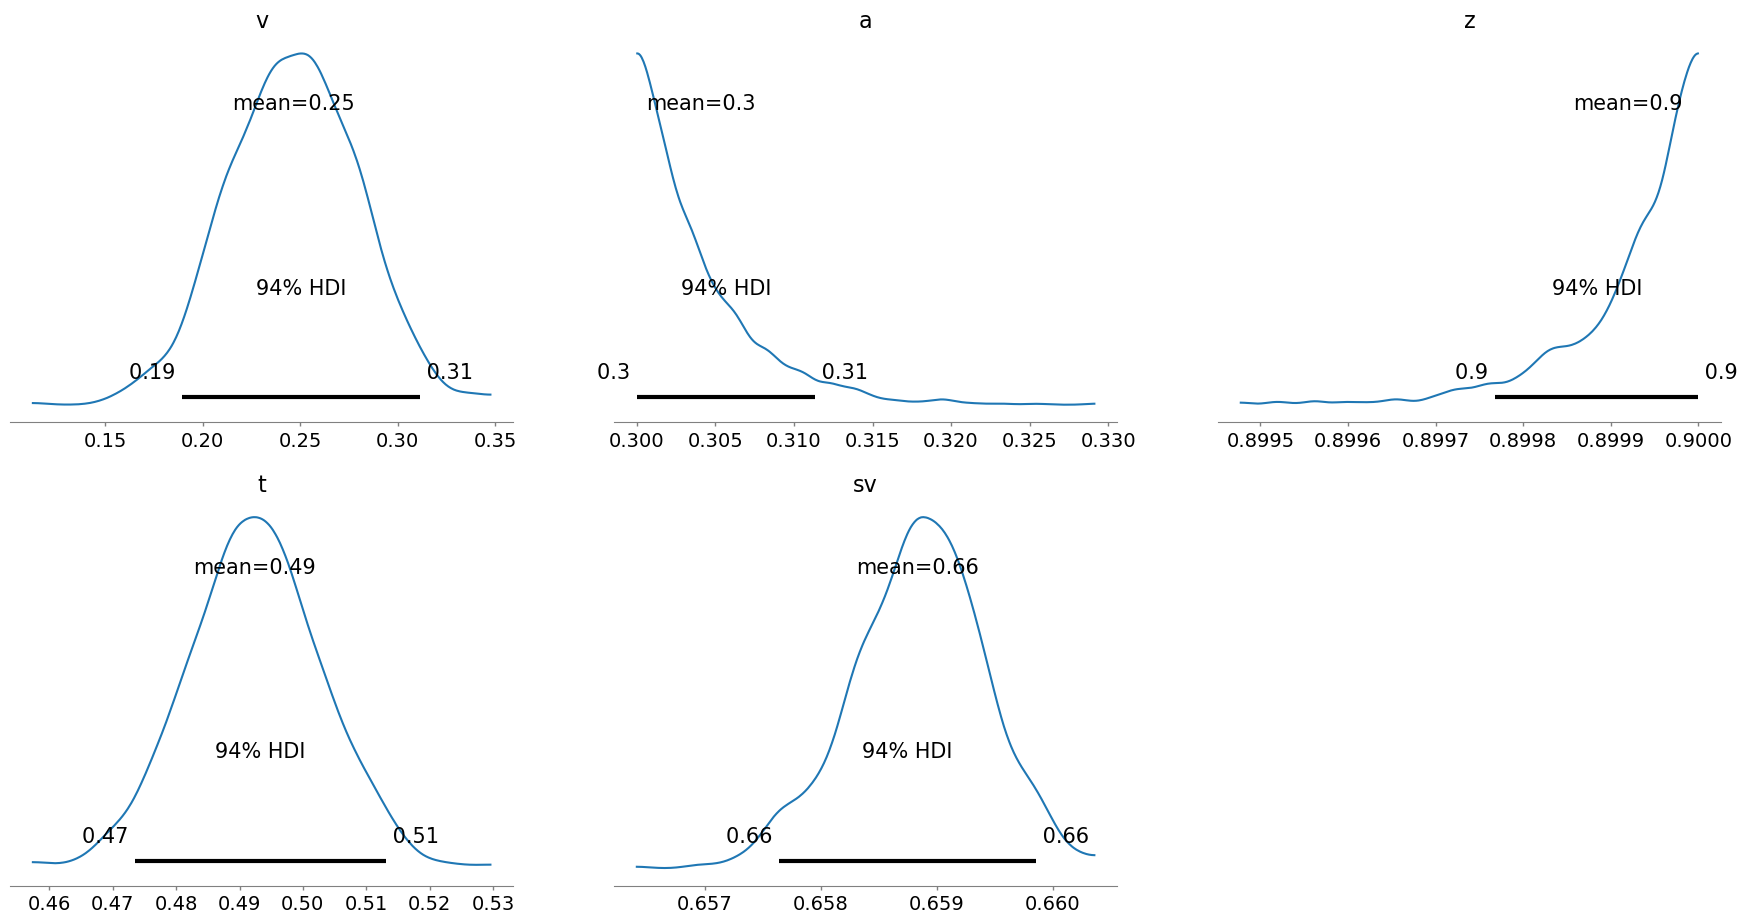

In [14]:
az.plot_posterior(trace_angle_nuts);

### Convergence Status.

Trace plots help us verify the convergence of model. In general, a largely overlapped distribution across samples from different chains indicates the convergence.



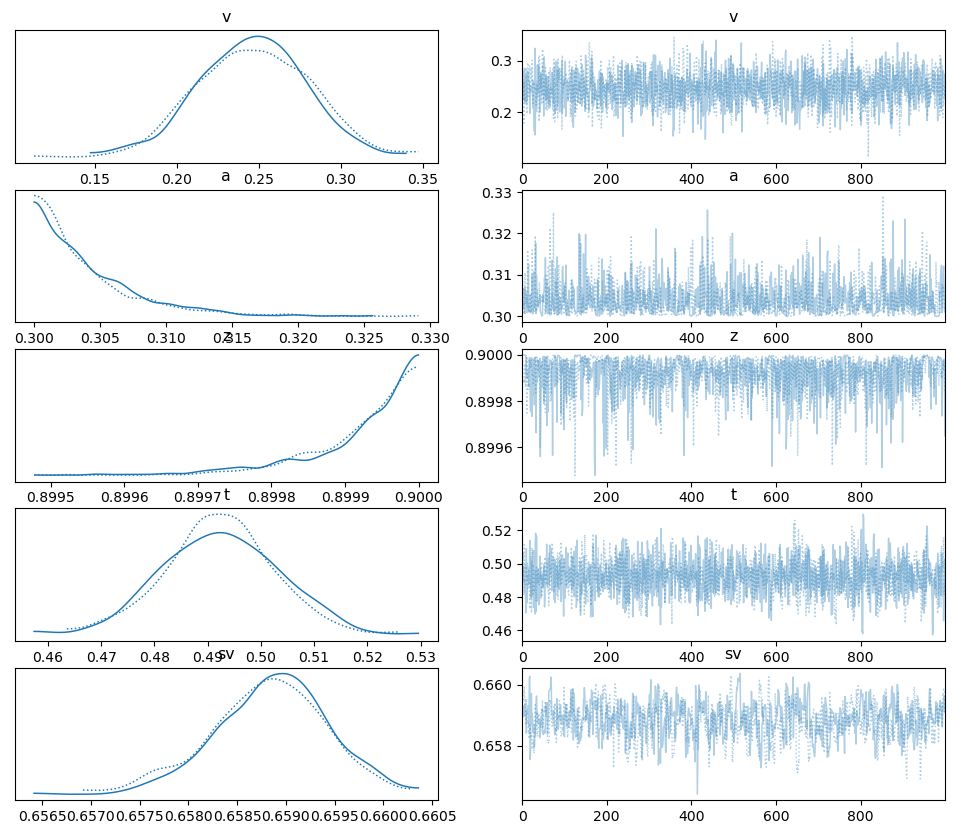

In [15]:
az.plot_trace(trace_angle_nuts);

You want the autocorrection to be as flat and close to 0 as possible. 

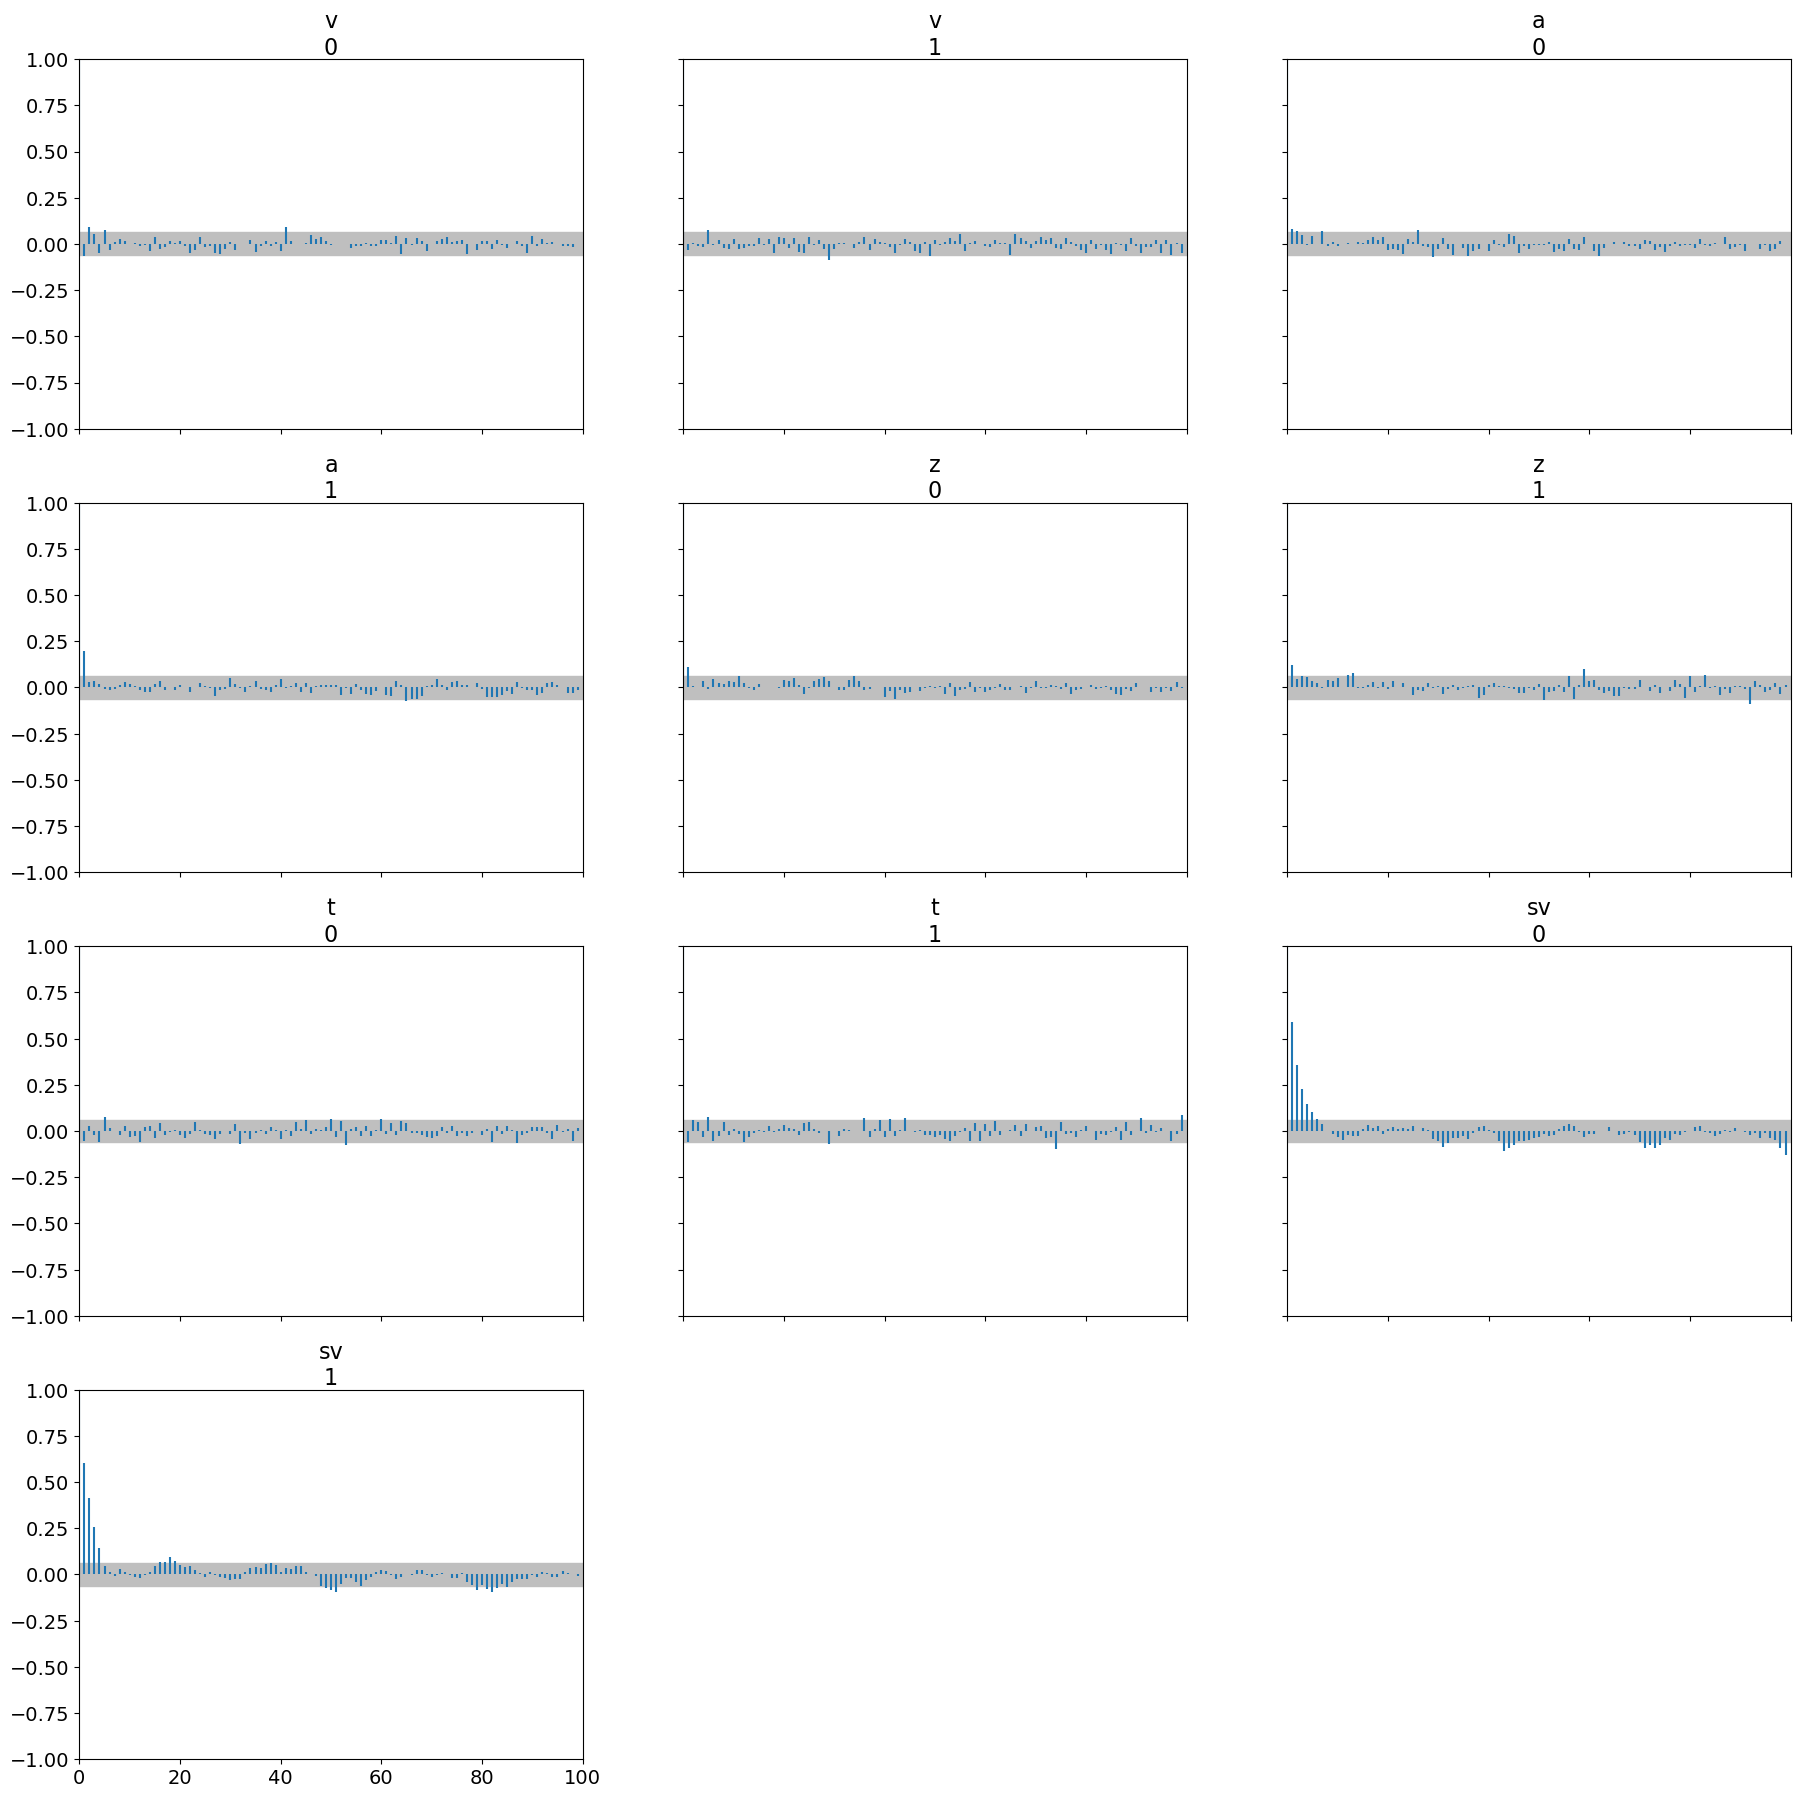

In [16]:
az.plot_autocorr(trace_angle_nuts);

The Gelman-Rubin statistic provides a more formal test for convergence that compares the intra-chain variance to the intra-chain variance of different runs of the same model.

In [14]:
az.rhat(trace_angle_nuts)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    v        float64 1.002
    a        float64 1.0
    z        float64 1.0
    t        float64 1.002
    sv       float64 1.001

In [37]:
trace_angle_nuts.observed_data.rt.shape

(1000,)

## Other Plots

array([<AxesSubplot: title={'center': '94.0% HDI'}>,
       <AxesSubplot: title={'center': 'ess'}>,
       <AxesSubplot: title={'center': 'r_hat'}>], dtype=object)

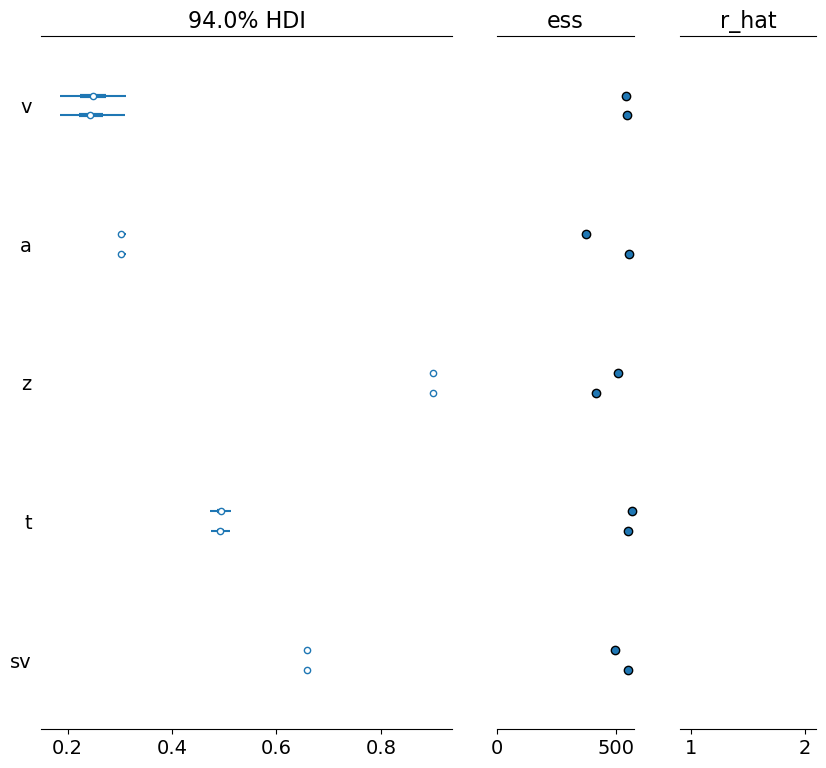

In [21]:
az.plot_forest(trace_angle_nuts, ess=True, r_hat=True)

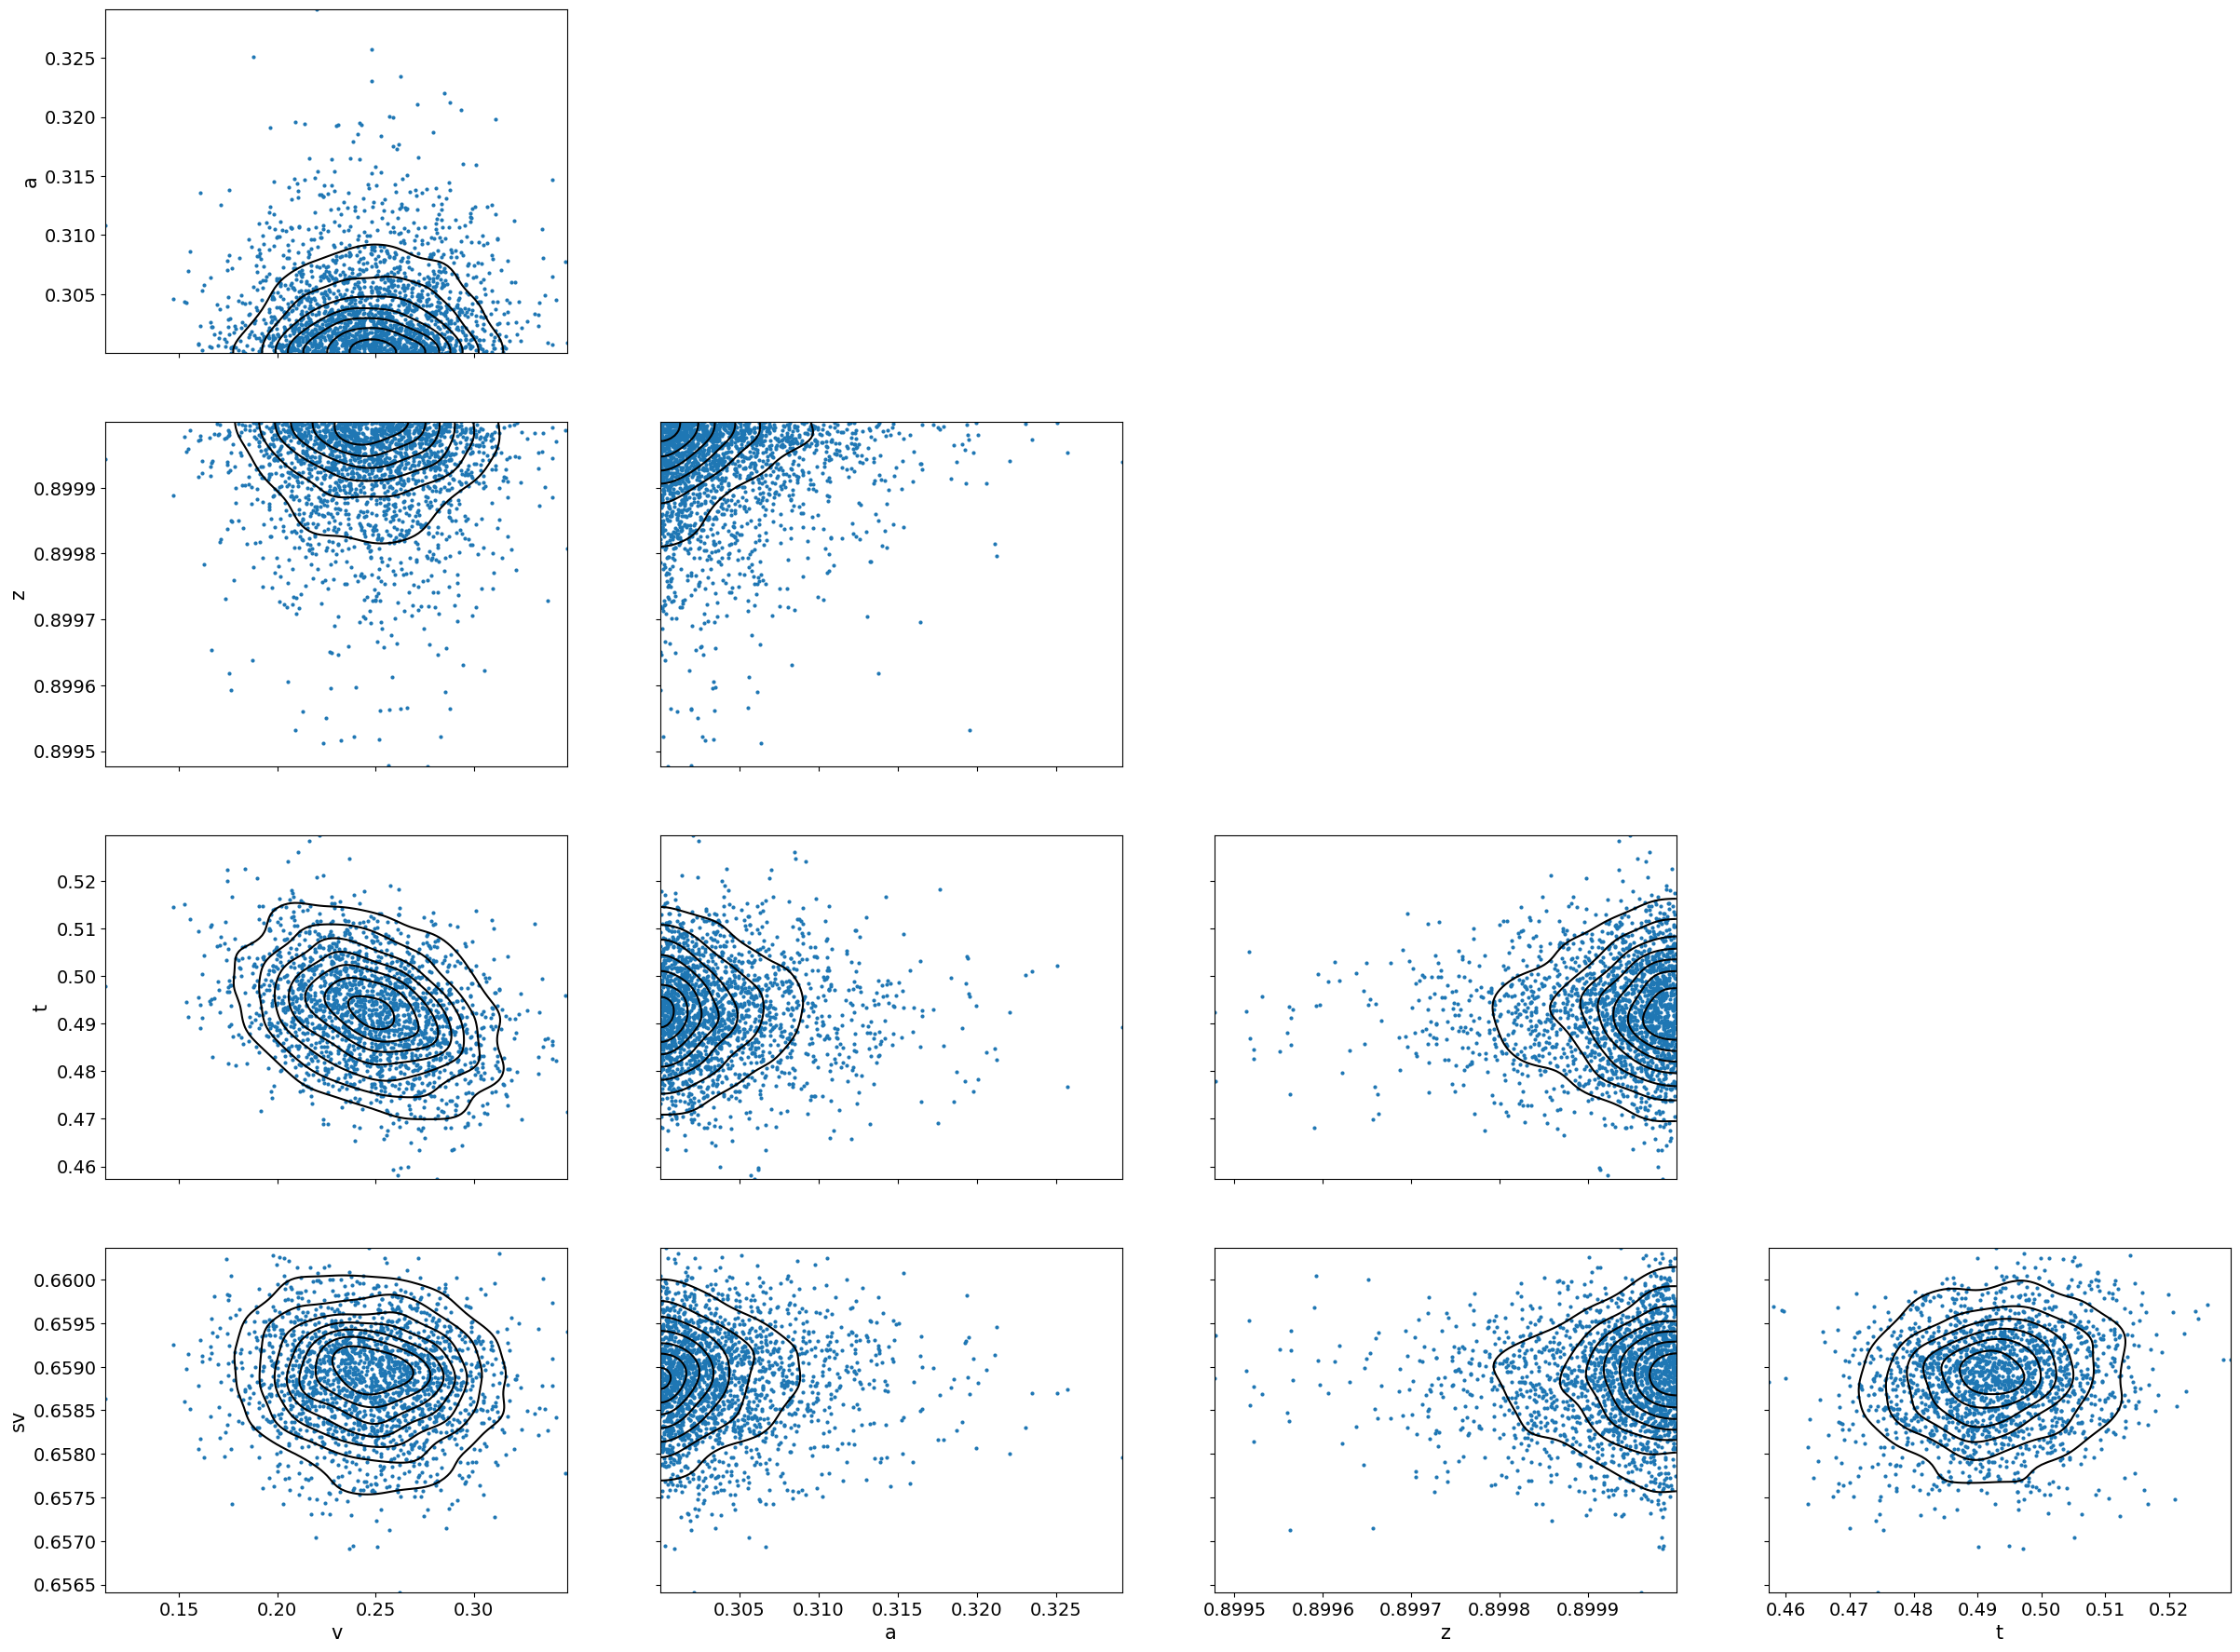

In [22]:
az.plot_pair(
    trace_angle_nuts,
    kind=["scatter", "kde"],
);